In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
img_size = 512
style_dim = 768
num_domains = 3

In [4]:
device = torch.device("cuda")

In [5]:
from core.model import Generator, StyleEncoder
style_encoder = StyleEncoder(img_size, style_dim, num_domains).to(device)
generator = Generator(img_size, style_dim, w_hpf=0).to(device)
ckpt = torch.load("./expr/checkpoints/000100_nets_ema.ckpt", map_location=device)
generator.load_state_dict(ckpt["generator"])
style_encoder.load_state_dict(ckpt["style_encoder"])
generator.eval()
style_encoder.eval()
del ckpt

In [6]:
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

In [7]:
def load_image(f_name):
    img = cv2.imread(f_name, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    img = to_tensor(img).unsqueeze(0)
    return img

In [8]:
def show_tensor(tensor):
    img = tensor.permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow((0.5*img + 0.5).clip(0, 1))
    plt.show()

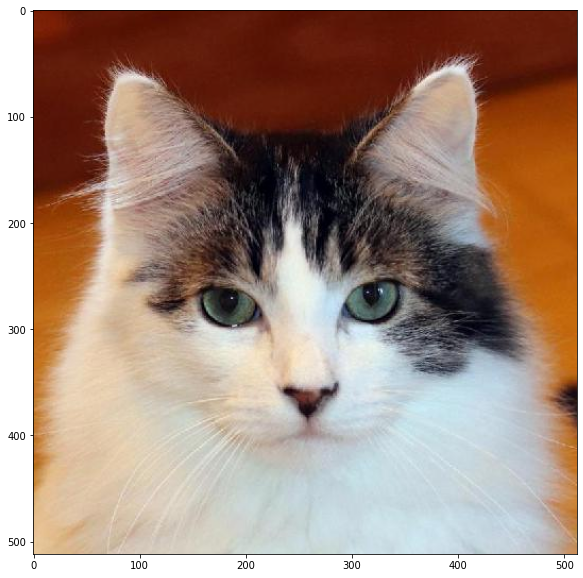

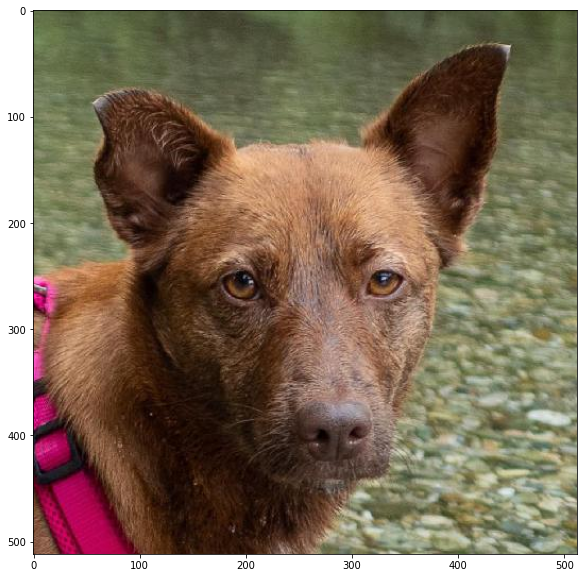

In [9]:
cat = load_image("./data/flickr_cat_000008.jpg")
show_tensor(cat[0])
dog = load_image("./data/flickr_dog_000043.jpg")
show_tensor(dog[0])

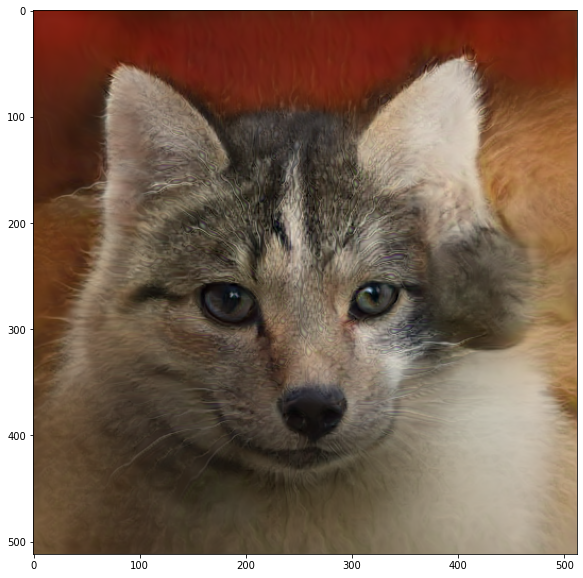

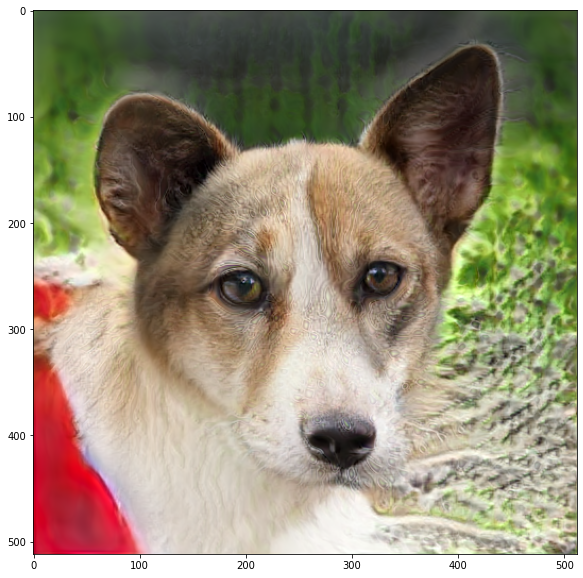

In [10]:
with torch.no_grad():
    cat_style = style_encoder(cat.to(device), torch.LongTensor([1]).to(device))
    dog_style = style_encoder(dog.to(device), torch.LongTensor([0]).to(device))
    new_cat = generator(cat.to(device), dog_style)
    new_dog = generator(dog.to(device), cat_style)
    show_tensor(new_cat[0])
    show_tensor(new_dog[0])